# Quantum Pulsar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from generate_toy_pulsar_data import generate_fake_data_2
print("Imports Successful")

Imports Successful


In [2]:
nchan, ntime = 64, 64
period_real = 4
dm_real = 20
noise_frac = 0.0

data = generate_fake_data_2(nchan, ntime, period_real, dm_real, noise_frac)

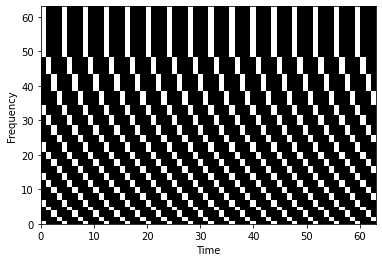

In [3]:
fig, ax = plt.subplots()
ax.imshow(data, vmin=0, vmax=1, origin='lower', aspect='auto',
          cmap='gray', extent=[0, ntime-1, 0, nchan-1])
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
fig.savefig("raw-data.svg")

## Period finding 

1 - create a superposition
$$
|0\rangle|0\rangle \rightarrow \sum_x |x\rangle|0\rangle 
$$

2 - Compute all values of $f$
$$
\sum_x |x\rangle|0\rangle  \rightarrow \sum_x |x\rangle|f(x)\rangle 
$$

for example :

$$
\sum_x |x\rangle|0\rangle  \rightarrow |0\rangle|a\rangle + |1\rangle|b\rangle + |2\rangle|c\rangle + |3\rangle|d\rangle + |4\rangle|e\rangle + |5\rangle|a\rangle + |6\rangle|b\rangle + ...
$$

3 - Measure the 2nd register. Let's say we measure $|b\rangle$, this collapse the wave function to :

$$
( |1\rangle + |6\rangle + |12\rangle + |18\rangle + ... ) |b\rangle
$$

4 - Apply iQFT on the first register that is now on a periodic superposition.


As a consequence must be injective within the period, i.e it can't take the values :

$$
\text{a b c d e d b} | \text{a b c d e d b} | \text{a b c d e d b}
$$


[2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9, 2, 0, 4, 9]


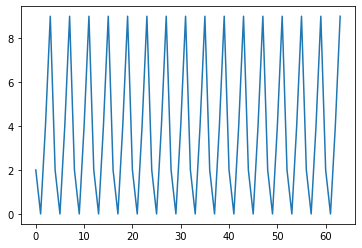

In [11]:
from utils import BitsToIntAFast

bits = []

n_count = 4
incr = 2
shift = 1

for icol in range(ntime):
    row_idx_start = shift
    row_idx_end = shift+n_count*incr
    d = data[row_idx_start:row_idx_end:incr,icol]
    bits.append(BitsToIntAFast(d, invert_bits_order=True))
plt.plot(bits)
print(bits)

We encode here the operation as an oracle computing

$$
    U|x\rangle|0\rangle \rightarrow |x\rangle|f(x)\rangle
$$

In [6]:
# from qiskit.quantum_info.operators import Operator
from utils import tobin 
from qiskit.quantum_info.operators import Operator
def BooleanBitsOracle(bit, nbit):
    
    npts = data.shape[0]
    nqbits_register1 = int(np.log2(npts))
    
    nqbits_register2 = nbit
    size = 2**(nqbits_register1+nqbits_register2)
    
    M = np.eye(size,size)
    
    
    for x in range(npts):
        
        xbin = tobin(x, nqbits_register1)
        y = int(bit[x])
        ybin = tobin(y, nqbits_register2)

        if ybin !=0:
            
            idx = int(ybin+xbin, 2)
            M[int(xbin, 2), int(xbin, 2)] = 0
            M[idx, idx] = 0
            M[int(xbin, 2),idx] = 1
            M[idx, int(xbin, 2)] = 1
    
    op = Operator(M)
    op.label = 'oracle'
    return op
    
oracle = BooleanBitsOracle(bits, n_count)

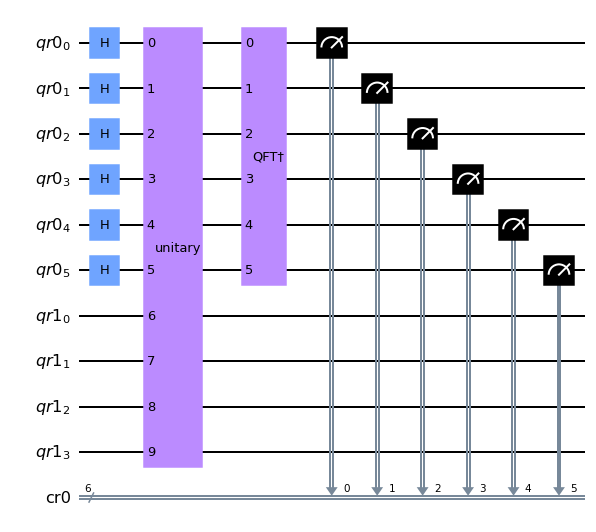

In [7]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
from utils import qft_dagger
nqubit_register1 = 6
nqubit_register2 = n_count

qc = QuantumCircuit(QuantumRegister(nqubit_register1, 'qr0'), 
                    QuantumRegister(nqubit_register2,'qr1'),
                    ClassicalRegister(nqubit_register1,'cr0'))


# Initialize counting qubits
# in state |+>
for q in range(nqubit_register1):
    qc.h(q)

# introduce the oracle
qc.append(oracle,list(range(0,nqubit_register1+nqubit_register2)))

# inv QFT
qc.append(qft_dagger(nqubit_register1), range(nqubit_register1))

# Measure circuit
# qc.measure(range(nqubit_register1, nqubit_register1+nqubit_register2),range(nqubit_register1, nqubit_register1+nqubit_register2))
qc.measure(range(nqubit_register1),range(nqubit_register1))
qc.draw('mpl')  # -1 means 'do not fold' 

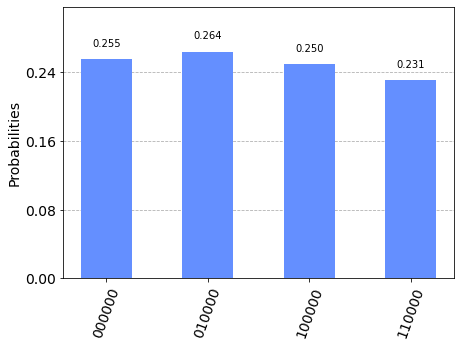

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


In [9]:
rows, measured_phases, measured_prob = [], [], []
norm = 0
for _, proba in counts.items():
    norm += proba
    
for output, proba in counts.items():
    norm_prob = proba/norm
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**nqubit_register1)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    measured_prob.append(norm_prob)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**nqubit_register1} = {phase:.2f}",
                norm_prob, phase])
# Print the rows in a table
headers=["Register Output", "Phase","Probability","NumPhase"]
df = pd.DataFrame(rows, columns=headers)
df.sort_values(by='Probability', inplace=True, ascending=False)
# print(df)


In [10]:
rows = []
for index, row in df.iterrows():
    frac = Fraction(row['NumPhase']).limit_denominator(20)
    rows.append([row['NumPhase'], f"{frac.numerator}/{frac.denominator}", frac.denominator, row['Probability']])
# Print as a table
headers=["Phase", "Fraction", "Guess for r", "Probability"]
df2 = pd.DataFrame(rows, columns=headers)
print(df2)
    

   Phase Fraction  Guess for r  Probability
0   0.25      1/4            4     0.263672
1   0.00      0/1            1     0.254883
2   0.50      1/2            2     0.250000
3   0.75      3/4            4     0.231445
